### **Importar todas as bibliotecas necessárias**

In [ ]:
# Instalar bibliotecas necessárias
!pip install openAI
!pip install nltk
!pip install scikit-learn

# Importar bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import openai
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import numpy as np
from openai import OpenAI
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Configurar o ambiente NLTK
nltk.download('stopwords')

# Configurar o estilo dos gráficos
sns.set(style="whitegrid")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Importação dos Dados**

In [ ]:
# Caminho do arquivo de dados
caminho_arquivo_dados = '/content/dados_embedding2 (2).xlsx'

# Carregar os dados a partir do arquivo Excel
dados_completos = pd.read_excel(caminho_arquivo_dados)

# Exibir as primeiras linhas do dataset
dados_completos.head()


,Transcrição,audio_id,Nota Final 2
0,<cliente>:\n Obrigado por assistir!\n E aí E a...,M_01924,45
1,"<cliente>:\n Então, eu falei, nós chegamos até...",M_01816,56
2,<cliente>:\n Mas se tiver os dados daquela emp...,M_02393,100
3,"<atendente>:\n Mais um momento, por favor, que...",M_01441,126
4,<atendente>:\n Mais um momento pra gente lazer...,M_02088,160


### *Apagar a coluna audio_id (para não influenciar na regressão linear)*

In [ ]:
# Remover a coluna 'audio_id' dos dados
dados_sem_audio_id = dados_completos.drop(columns=['audio_id'])

# Exibir as primeiras linhas do dataset
dados_sem_audio_id.head()


,Transcrição,Nota Final 2
0,<cliente>:\n Obrigado por assistir!\n E aí E a...,45
1,"<cliente>:\n Então, eu falei, nós chegamos até...",56
2,<cliente>:\n Mas se tiver os dados daquela emp...,100
3,"<atendente>:\n Mais um momento, por favor, que...",126
4,<atendente>:\n Mais um momento pra gente lazer...,160


### **Divisão dos Dados em Treino (75%) e Validação (25%)**

Divisão dos Dados em Treino (75%) e Validação (25%). Os 75% serão utilizados durante todo o codigo e os 25% apenas no final para validar

In [ ]:
# Definir a proporção de dados para treino (75%) e validação (25%)
proporcao_treino = 0.75

# Divisão dos dados em treino e validação aleatóriamente
dados_de_treino, dados_de_validacao = train_test_split(dados_sem_audio_id,
                                                       test_size=(1 - proporcao_treino),
                                                       random_state=42)
# Verificar o tamanho dos conjuntos
print(f"Tamanho do conjunto de treino: {dados_de_treino.shape}")
print(f"Tamanho do conjunto de validação: {dados_de_validacao.shape}")


Tamanho do conjunto de treino: (420, 2)
Tamanho do conjunto de validação: (141, 2)


### **Escalonamento dos Dados de Treino na coluna Nota Final 2 para 0 a 0.1**

Vamos deixar esses dados com valores mais próximos aos valores dos embbedings

In [ ]:
# Inicializar o MinMaxScaler para escalar a coluna 'Nota Final 2' de 0 a 0.1
escalonador_nota_final = MinMaxScaler(feature_range=(0, 0.1))

# Aplicar o escalonamento apenas na coluna 'Nota Final 2' dos dados de treino
dados_de_treino['Nota Final 2'] = escalonador_nota_final.fit_transform(dados_de_treino[['Nota Final 2']])

# Exibir as primeiras linhas dos dados de treino após o escalonamento
dados_de_treino.head()


,Transcrição,Nota Final 2
560,"<atendente>:\n Boa tarde, como posso ajudar?\n...",0.100000
421,"<atendente>:\n Karina, boa tarde.\nComo eu pos...",0.091626
380,"<atendente>:\n Vanessa, boa tarde.\nA gente po...",0.090655
184,<atendente>:\n Como posso ajudar?\n</atendente...,0.068568
331,"<atendente>:\n Ele usa o Bom Dia, que possa aj...",0.089684


### **Pré-processamento do Texto dos Dados de treino**

In [ ]:
# Download das stopwords em português
nltk.download('stopwords')
stopwords_portugues = set(nltk.corpus.stopwords.words('portuguese'))

# Deixando a palavra "não" nas transcrições, pois podem carregar informções importantes
stopwords_portugues.discard('não')

# Aplicar as transformações de pré-processamento na coluna 'Transcrição' dos dados de treino
dados_de_treino['Transcrição'] = dados_de_treino['Transcrição'].str.lower()
dados_de_treino['Transcrição'] = dados_de_treino['Transcrição'].str.replace(r'[^\w\s]', '', regex=True)
dados_de_treino['Transcrição'] = dados_de_treino['Transcrição'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_portugues]))

# Visualizar as primeiras linhas dos dados de treino após o pré-processamento
dados_de_treino.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Transcrição,Nota Final 2
560,atendente boa tarde posso ajudar atendente cli...,0.100000
421,atendente karina boa tarde posso ajudar atende...,0.091626
380,atendente vanessa boa tarde gente pode ajudar ...,0.090655
184,atendente posso ajudar atendente cliente queri...,0.068568
331,atendente usa bom dia possa ajudar atendente c...,0.089684


### **Pré-processamento do Texto igual com os Dados de Validação**

In [ ]:
dados_de_validacao['Transcrição'] = dados_de_validacao['Transcrição'].str.lower()
dados_de_validacao['Transcrição'] = dados_de_validacao['Transcrição'].str.replace(r'[^\w\s]', '', regex=True)
dados_de_validacao['Transcrição'] = dados_de_validacao['Transcrição'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_portugues]))

dados_de_validacao.head()

,Transcrição,Nota Final 2
513,atendente maíra boa tarde posso ajudar atenden...,832
342,atendente juliana bom dia possa ajudar atenden...,798
177,cliente boa tarde queria ver promoção desse ca...,618
86,atendente tamires boa tarde gente pode ajudar ...,577
333,atendente aline boa noite posso ajudar atenden...,795


### **Geração dos Embeddings**

In [ ]:
!pip install python-dotenv

In [ ]:
import dotenv
import os

In [ ]:
dotenv.load_dotenv()

In [ ]:
# Configuração do cliente OpenAI com a chave de API
client = openai.Client(
    api_key=os.getenv("OPENAI_KEY")
)

# Função para gerar embeddings utilizando o modelo especificado
def gerar_embedding(texto, modelo="text-embedding-3-small"):
    texto = texto.replace("\n", " ")
    return client.embeddings.create(input=[texto], model=modelo).data[0].embedding

# Aplicar a geração de embeddings na coluna 'Transcrição' dos dados de treino
dados_de_treino['embedding'] = dados_de_treino['Transcrição'].apply(gerar_embedding)
dados_de_validacao['embedding'] = dados_de_validacao['Transcrição'].apply(gerar_embedding)

# Verificar o tamanho dos embeddings para garantir que foram gerados corretamente
print(f"Tamanho de um embedding: {len(dados_de_treino['embedding'].iloc[0])}")


Tamanho de um embedding: 1536


### **Expansão dos Embeddings em Colunas Individuais e Exclusão da coluna Transcrição**

In [ ]:
# Expandir os embeddings em múltiplas colunas
embeddings_expandidos = pd.DataFrame(dados_de_treino['embedding'].tolist(), index=dados_de_treino.index)
embeddings_expandidos_validacao = pd.DataFrame(dados_de_validacao['embedding'].tolist(), index=dados_de_validacao.index)

# Renomear as colunas dos embeddings para 'embedding_1', 'embedding_2', ..., 'embedding_X'
embeddings_expandidos.columns = [f'embedding_{i+1}' for i in range(embeddings_expandidos.shape[1])]
embeddings_expandidos_validacao.columns = [f'embedding_{i+1}' for i in range(embeddings_expandidos_validacao.shape[1])]

# Concatenar os embeddings expandidos ao dataframe original, excluindo a coluna 'Transcrição' e 'embedding'
dados_de_treino_expandidos = pd.concat([dados_de_treino.drop(columns=['Transcrição', 'embedding']), embeddings_expandidos], axis=1)
dados_de_validacao_expandidos = pd.concat([dados_de_validacao.drop(columns=['Transcrição', 'embedding']), embeddings_expandidos_validacao], axis=1)

# Exibir as primeiras linhas do dataframe final
dados_de_treino_expandidos.head()


,Nota Final 2,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536
560,0.100000,0.010004,0.008174,-0.020072,-0.015238,-0.023903,-0.004845,-0.010420,-0.003231,-0.006195,...,-0.036153,-0.008558,-0.050581,-0.010959,0.003850,0.032056,0.000622,-0.027360,0.010746,0.008238
421,0.091626,0.006767,0.003315,-0.041269,-0.003781,-0.030711,0.001048,-0.016486,0.004860,-0.010246,...,-0.034003,0.012633,-0.038657,-0.021919,-0.001303,0.035803,0.002610,-0.012556,0.010729,-0.011168
380,0.090655,-0.018287,-0.009952,-0.024833,-0.021391,-0.021229,0.001322,0.001902,0.010039,-0.001902,...,-0.032157,-0.000982,-0.047201,-0.023042,-0.000312,0.039760,0.008667,-0.013649,0.020891,0.008801
184,0.068568,0.006184,-0.003709,-0.020473,0.000282,-0.050339,-0.009923,-0.021448,0.013909,0.000449,...,-0.034780,-0.000032,-0.033166,-0.012007,-0.003971,0.031022,0.008574,-0.006274,0.009411,-0.006437
331,0.089684,-0.022464,0.002600,-0.009435,-0.011810,-0.029098,-0.014537,-0.006345,-0.004096,-0.009385,...,-0.032618,0.011810,-0.021331,-0.021060,-0.009238,0.021073,0.005693,-0.021085,0.019940,-0.010943


In [ ]:
dados_de_validacao_expandidos.head()

,Nota Final 2,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536
513,832,0.006735,0.009684,-0.041799,-0.019358,-0.026818,0.000315,-0.005374,-0.020303,-0.005281,...,-0.042045,0.005145,-0.045169,-0.010922,-0.007562,0.032181,-0.003216,-0.013748,0.015012,-0.016265
342,798,-0.011572,0.006661,-0.013025,-0.022147,-0.057604,-0.008488,-0.008499,-0.010569,-0.004027,...,-0.032005,0.013867,-0.041684,-0.005377,0.000068,0.027070,-0.015148,-0.016204,0.026287,-0.028422
177,618,-0.017786,0.012706,-0.008260,-0.006634,-0.021265,0.015157,-0.025604,0.000476,0.022675,...,-0.020464,0.007166,-0.025484,-0.010423,-0.022795,0.013435,-0.013543,-0.009479,0.009580,-0.026392
86,577,0.019436,0.003438,-0.013937,0.002483,-0.048351,0.011573,-0.033875,-0.001538,-0.029148,...,-0.036839,0.014574,-0.027776,-0.019313,-0.013251,0.030152,-0.017550,-0.012859,0.022840,-0.003585
333,795,-0.000058,0.019831,-0.038249,-0.012221,-0.052579,-0.003974,0.000822,-0.001407,0.005991,...,-0.036988,0.000493,-0.036531,-0.014645,-0.002679,0.035074,0.004498,-0.013623,0.019570,-0.013210


### **Análise de Variância e Seleção dos Embeddings mais Relevantes**

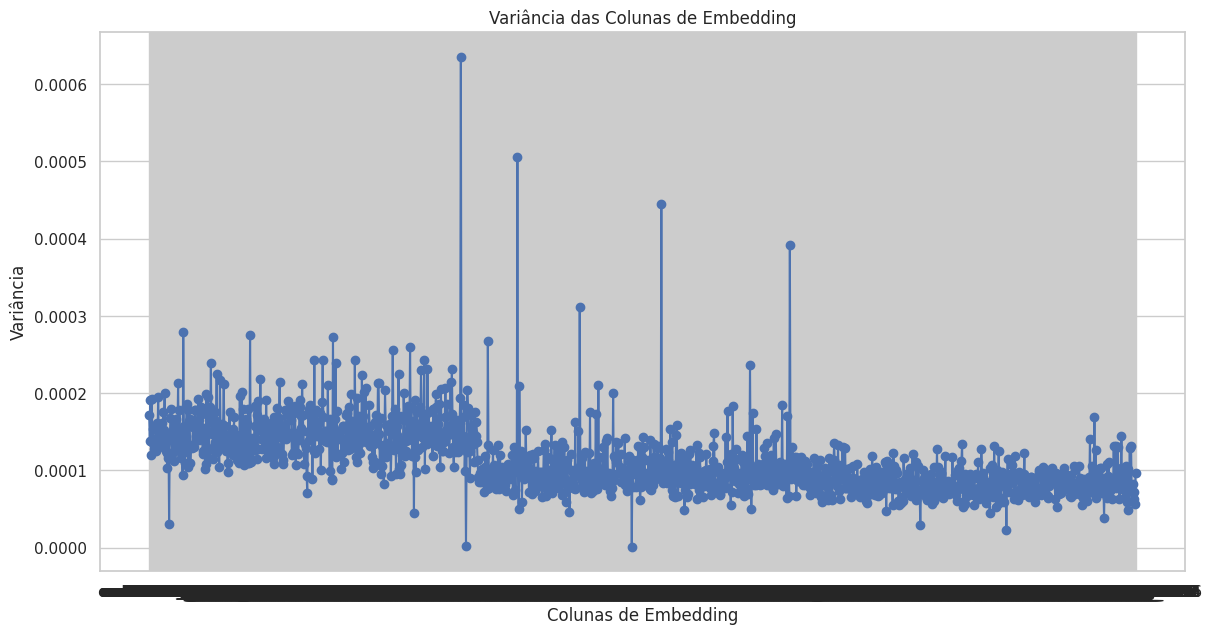

In [ ]:
df = dados_de_treino_expandidos
# Calcular a variância de cada coluna de embedding
variances = df[[f'embedding_{i+1}' for i in range(1536)]].var()

# Plotar as variâncias
plt.figure(figsize=(14, 7))
plt.plot(variances, marker='o')
plt.title('Variância das Colunas de Embedding')
plt.xlabel('Colunas de Embedding')
plt.ylabel('Variância')
plt.grid(True)
plt.show()


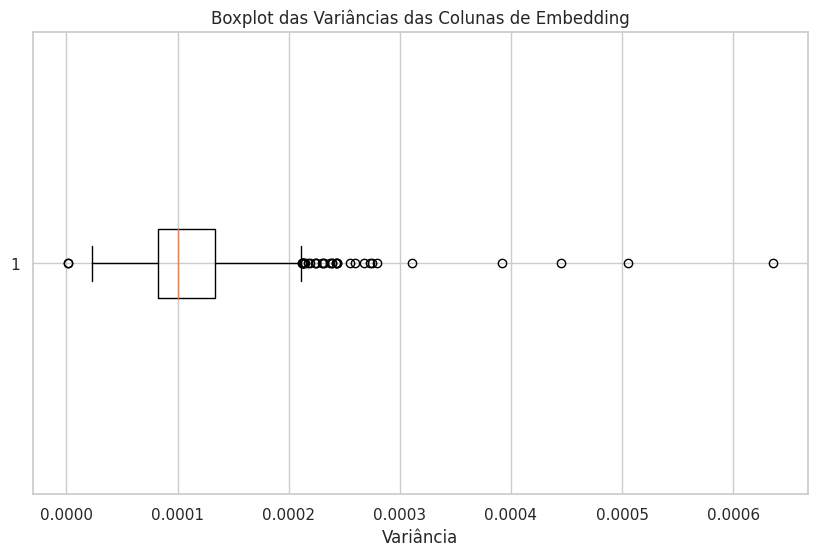

In [ ]:
# Plotar o boxplot das variâncias
plt.figure(figsize=(10, 6))
plt.boxplot(variances, vert=False)
plt.title('Boxplot das Variâncias das Colunas de Embedding')
plt.xlabel('Variância')
plt.show()

### **Excluindo a Coluna com as Notas, Coluna Alvo**

In [ ]:
X = df.drop(columns=['Nota Final 2'])  # Exclui a coluna alvo
y = df['Nota Final 2']  # A coluna alvo

In [ ]:
variances = df[[f'embedding_{i+1}' for i in range(1536)]].var()

# Ordenar as variâncias em ordem decrescente e selecionar as n maiores
n = 10
top_variances = variances.sort_values(ascending=False).head(n)

# Exibir as top variâncias
top_variances

,0
embedding_486,0.000635
embedding_574,0.000506
embedding_798,0.000445
embedding_998,0.000392
embedding_671,0.000311
embedding_54,0.000279
embedding_158,0.000275
embedding_287,0.000273
embedding_528,0.000268
embedding_407,0.000260


In [ ]:
top_embeddings = list(top_variances.index)

### **Cross Validation e Gradient Boosting Regression (GradientBoostingRegressor)**

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import pandas as pd

# Dividir os dados em treino (75%) e validação (25%)
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar o número de folds para validação cruzada usando apenas os 75% de treino
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Preparar para armazenar os valores de R² de cada fold
r2_scores = []  # Para armazenar os valores de R² de cada fold
models = []     # Para armazenar os modelos ajustados

# Loop através dos folds usando os 75% de treino
for train_index, test_index in kf.split(X_train_full):
    X_train, X_test = X_train_full.iloc[train_index], X_train_full.iloc[test_index]
    y_train, y_test = y_train_full.iloc[train_index], y_train_full.iloc[test_index]

    # Ajustar o modelo de Gradient Boosting Regression
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models.append(model)  # Armazenar o modelo ajustado

    # Calcular e armazenar o R² para o conjunto de teste
    y_test_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_test_pred)
    r2_scores.append(r2)

# Exibir o R-squared médio
print(f'R-squared Médio: {np.mean(r2_scores):.4f}')


R-squared Médio: 0.1044


In [ ]:
# X_train e y_train já estão definidos
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
models = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_fold, y_train_fold)

    y_val_pred = model.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_val_pred)
    r2_scores.append(r2)
    models.append(model)


In [ ]:
best_model_index = np.argmax(r2_scores)
best_model = models[best_model_index]

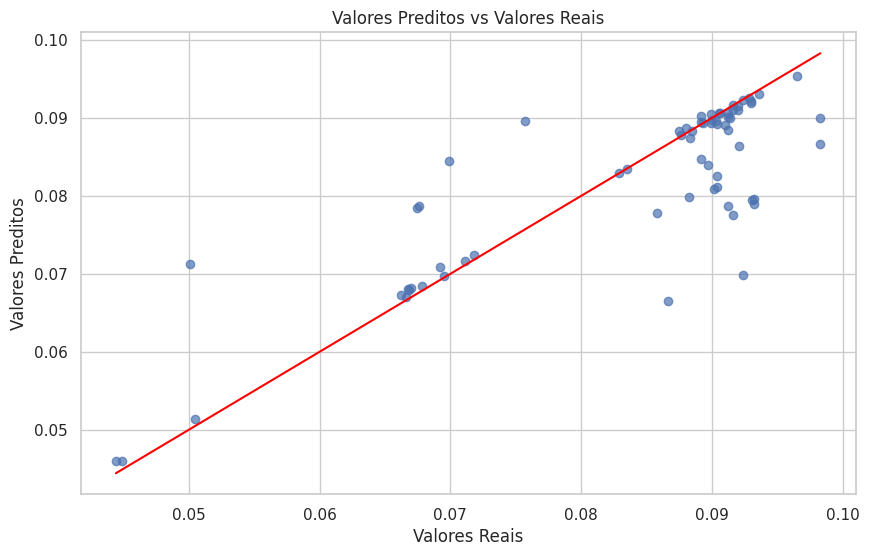

R² para o conjunto de teste: 0.9928


In [ ]:
# Fazer predições no conjunto de teste correspondente ao melhor fold
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Realizar a predição com o modelo do melhor fold
y_test_pred = best_model.predict(X_test)

# Plotar valores preditos versus valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Linha de identidade
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Preditos vs Valores Reais')
plt.grid(True)
plt.show()

# Calcular o R² para o conjunto de teste final
final_r2 = sm.OLS(y_test, y_test_pred).fit().rsquared
print(f"R² para o conjunto de teste: {final_r2:.4f}")


### **Analisando qual é o maior MSE**

In [ ]:
variances = df[[f'embedding_{i+1}' for i in range(1536)]].var()

In [ ]:
df = dados_de_treino_expandidos  # Substitua pelo seu DataFrame

# Supondo que X sejam os embeddings e y a variável alvo
X = df[[f'embedding_{i+1}' for i in range(1536)]]
y = df['Nota Final 2']  # Substitua 'target' pela sua variável de resposta

# Dividir os dados em treino (75%) e validação (25%)
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Lista para armazenar resultados
results = []

# Definir valores de N (número de embeddings)
n_values = [i for i in range(10, len(X_train_full.columns), 10)]

# Iterar sobre os diferentes valores de N
for n in n_values:
    # Selecionar os top N embeddings
    top_n_embeddings = X_train_full.var().sort_values(ascending=False).head(n).index
    X_train_top_n = X_train_full[top_n_embeddings]
    X_val_top_n = X_val[top_n_embeddings]

    # Configurar validação cruzada
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    r2_scores = []
    mse_scores = []

    # Loop através dos folds usando os 75% de treino
    for train_index, test_index in kf.split(X_train_top_n):
        X_train, X_test = X_train_top_n.iloc[train_index], X_train_top_n.iloc[test_index]
        y_train, y_test = y_train_full.iloc[train_index], y_train_full.iloc[test_index]

        # Ajustar o modelo de regressão linear
        model = sm.OLS(y_train, X_train).fit()

        # Predizer no conjunto de teste
        y_test_pred = model.predict(X_test)

        # Calcular e armazenar o R² e MSE
        r2 = sm.OLS(y_test, y_test_pred).fit().rsquared
        mse = mean_squared_error(y_test, y_test_pred)

        r2_scores.append(r2)
        mse_scores.append(mse)

    # Calcular médias dos scores
    mean_r2 = np.mean(r2_scores)
    mean_mse = np.mean(mse_scores)

    # Armazenar os resultados
    results.append({
        'top_n': n,
        'mean_r2': mean_r2,
        'mean_mse': mean_mse
    })

    # Printar resultados para esse N
    print(f'Top {n} embeddings -> R² médio: {mean_r2:.4f}, MSE médio: {mean_mse:.4f}')

# Exibir todos os resultados em um DataFrame para fácil visualização
results_df = pd.DataFrame(results)

Top 10 embeddings -> R² médio: 0.9469, MSE médio: 0.0004
Top 20 embeddings -> R² médio: 0.9522, MSE médio: 0.0003
Top 30 embeddings -> R² médio: 0.9544, MSE médio: 0.0003
Top 40 embeddings -> R² médio: 0.9565, MSE médio: 0.0003
Top 50 embeddings -> R² médio: 0.9575, MSE médio: 0.0003
Top 60 embeddings -> R² médio: 0.9541, MSE médio: 0.0003
Top 70 embeddings -> R² médio: 0.9526, MSE médio: 0.0003
Top 80 embeddings -> R² médio: 0.9489, MSE médio: 0.0003
Top 90 embeddings -> R² médio: 0.9482, MSE médio: 0.0003
Top 100 embeddings -> R² médio: 0.9415, MSE médio: 0.0004
Top 110 embeddings -> R² médio: 0.9426, MSE médio: 0.0004
Top 120 embeddings -> R² médio: 0.9398, MSE médio: 0.0004
Top 130 embeddings -> R² médio: 0.9308, MSE médio: 0.0005
Top 140 embeddings -> R² médio: 0.9263, MSE médio: 0.0005
Top 150 embeddings -> R² médio: 0.9179, MSE médio: 0.0006
Top 160 embeddings -> R² médio: 0.9030, MSE médio: 0.0007
Top 170 embeddings -> R² médio: 0.8817, MSE médio: 0.0009
Top 180 embeddings -> R

### **50 embeddings com maior variância**

In [ ]:
X = df.drop(columns=['Nota Final 2'])  # Exclui a coluna alvo
y = df['Nota Final 2']  # A coluna alvo

In [ ]:
variances = df[[f'embedding_{i+1}' for i in range(1536)]].var()

# Ordenar as variâncias em ordem decrescente e selecionar as n maiores
n = 50
top_variances = variances.sort_values(ascending=False).head(n)

# Exibir as top variâncias
top_variances

,0
embedding_486,0.000635
embedding_574,0.000506
embedding_798,0.000445
embedding_998,0.000392
embedding_671,0.000311
embedding_54,0.000279
embedding_158,0.000275
embedding_287,0.000273
embedding_528,0.000268
embedding_407,0.000260


In [ ]:
top_embeddings = list(top_variances.index) + ['Nota Final 2']

In [ ]:
df = df[top_embeddings]

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

# Dividir os dados em treino (75%) e validação (25%)
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar o número de folds para validação cruzada usando apenas os 75% de treino
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Preparar para armazenar os valores de R² de cada fold
r2_scores = []  # Para armazenar os valores de R² de cada fold
models = []     # Para armazenar os modelos ajustados

# Loop através dos folds usando os 75% de treino
for train_index, test_index in kf.split(X_train_full):
    X_train, X_test = X_train_full.iloc[train_index], X_train_full.iloc[test_index]
    y_train, y_test = y_train_full.iloc[train_index], y_train_full.iloc[test_index]

    # Ajustar o modelo de Gradient Boosting Regression
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models.append(model)  # Armazenar o modelo ajustado

    # Calcular e armazenar o R² para o conjunto de teste
    y_test_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_test_pred)
    r2_scores.append(r2)

# Exibir o R-squared médio
print(f'R-squared Médio: {np.mean(r2_scores):.4f}')


R-squared Médio: 0.1044


In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# X_train e y_train já estão definidos
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
models = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Importar e ajustar o modelo de Regressão Linear
    model = LinearRegression()
    model.fit(X_train_fold, y_train_fold)

    # Fazer predições e calcular o R²
    y_val_pred = model.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_val_pred)
    r2_scores.append(r2)
    models.append(model)

# Exibir os R² de cada fold
print(r2_scores)


[-0.13265979281654605, -2.0584228585951174e+22, -1.0816969005115636e+22, -1.372999300842269e+22, -0.4189645268875939]


In [ ]:
best_model_index = np.argmax(r2_scores)
best_model = models[best_model_index]

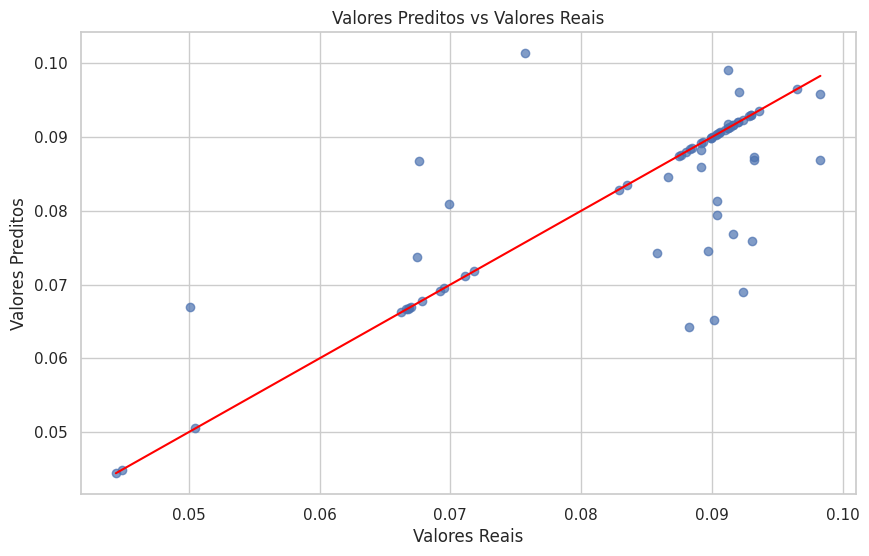

R² para o conjunto de teste: 0.9906


In [ ]:
# Fazer predições no conjunto de teste correspondente ao melhor fold
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Realizar a predição com o modelo do melhor fold
y_test_pred = best_model.predict(X_test)

# Plotar valores preditos versus valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Linha de identidade
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Preditos vs Valores Reais')
plt.grid(True)
plt.show()

# Calcular o R² para o conjunto de teste final
final_r2 = sm.OLS(y_test, y_test_pred).fit().rsquared
print(f"R² para o conjunto de teste: {final_r2:.4f}")


### **voltar escalonamento**

In [ ]:
# Inicializar o MinMaxScaler para escalar a coluna 'Nota Final 2' de 0 a 0.1
escalonador_nota_final = MinMaxScaler(feature_range=(0, 0.1))

# Aplicar o escalonamento apenas na coluna 'Nota Final 2' dos dados de treino
dados_de_treino['Nota Final 2'] = escalonador_nota_final.fit_transform(dados_de_treino[['Nota Final 2']])

# Exibir as primeiras linhas dos dados de treino após o escalonamento
dados_de_treino.head()


,Transcrição,Nota Final 2,embedding
560,atendente boa tarde posso ajudar atendente cli...,0.100000,"[0.010004079900681973, 0.008174000307917595, -..."
421,atendente karina boa tarde posso ajudar atende...,0.091626,"[0.006766649428755045, 0.003314725123345852, -..."
380,atendente vanessa boa tarde gente pode ajudar ...,0.090655,"[-0.018287302926182747, -0.009951641783118248,..."
184,atendente posso ajudar atendente cliente queri...,0.068568,"[0.006183963734656572, -0.003709173761308193, ..."
331,atendente usa bom dia possa ajudar atendente c...,0.089684,"[-0.022463630884885788, 0.0026002423837780952,..."


In [ ]:
df.loc[:, 'Nota Final 2'] = escalonador_nota_final.inverse_transform(dados_de_treino[['Nota Final 2']])

In [ ]:
df

,embedding_486,embedding_574,embedding_798,embedding_998,embedding_671,embedding_54,embedding_158,embedding_287,embedding_528,embedding_407,...,embedding_145,embedding_335,embedding_25,embedding_397,embedding_723,embedding_315,embedding_447,embedding_90,embedding_142,Nota Final 2
560,0.001871,-0.096893,0.090661,-0.125406,-0.050922,0.104405,-0.020734,-0.003369,-0.058434,-0.057367,...,0.007518,-0.023434,-0.008846,0.018973,0.000171,0.009401,0.033955,-0.027937,-0.021844,0.100000
421,0.018132,-0.084734,0.093954,-0.149009,-0.069456,0.084734,-0.005965,0.021403,-0.026123,-0.040216,...,-0.019120,0.011086,-0.022610,0.000757,-0.005142,0.027571,0.054265,-0.013874,-0.028537,0.091626
380,0.001943,-0.089797,0.092820,-0.151507,-0.057059,0.080125,-0.004990,0.024740,-0.046898,-0.034017,...,-0.010585,0.002966,-0.018252,0.011585,0.011428,0.005159,0.042318,-0.027716,-0.001671,0.090655
184,0.010291,-0.069896,0.087912,-0.155978,-0.024760,0.092729,-0.034563,0.017896,-0.025723,-0.022929,...,-0.003806,-0.027048,-0.016450,0.007304,0.023544,-0.010357,0.027843,-0.005404,-0.021015,0.068568
331,-0.041973,-0.030723,0.064548,-0.114226,-0.019103,0.083602,-0.027203,0.046847,-0.051352,-0.069570,...,-0.002785,0.006505,-0.022882,0.008364,0.049285,-0.017442,0.052386,0.007071,-0.001608,0.089684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.036626,-0.034706,0.087527,-0.134983,-0.041130,0.100770,-0.012012,0.026854,-0.010399,-0.027543,...,-0.010719,-0.004138,-0.022756,0.027617,0.022940,0.019223,0.046668,-0.018744,-0.006406,0.060437
106,0.005877,-0.088337,0.106764,-0.137786,-0.045605,0.083255,-0.040434,0.030359,-0.050819,-0.059436,...,-0.005648,-0.004966,-0.026360,0.022449,0.021267,0.006778,0.049449,-0.006391,-0.017555,0.064684
270,-0.048187,-0.075650,0.075511,-0.114467,-0.043687,0.114744,-0.011349,0.003142,-0.023147,-0.047356,...,0.005403,0.008735,-0.000378,0.022097,-0.000826,0.014389,0.029586,-0.025801,-0.026540,0.087621
435,0.018518,-0.087027,0.098242,-0.164577,-0.065466,0.120672,0.002244,-0.001831,-0.030885,-0.030885,...,-0.017105,0.011650,-0.019333,-0.019920,-0.006162,-0.003260,0.022952,-0.019974,-0.026343,0.092112


### **conferir os 25%**

In [ ]:
# Inicializar o MinMaxScaler para escalar a coluna 'Nota Final 2' de 0 a 0.1
escalonador_nota_final = MinMaxScaler(feature_range=(0, 0.1))

# Aplicar o escalonamento apenas na coluna 'Nota Final 2' dos dados de treino
dados_de_validacao_expandidos['Nota Final 2'] = escalonador_nota_final.fit_transform(dados_de_validacao_expandidos[['Nota Final 2']])

# Exibir as primeiras linhas dos dados de treino após o escalonamento
dados_de_validacao_expandidos.head()

,Nota Final 2,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536
513,0.094591,0.006735,0.009684,-0.041799,-0.019358,-0.026818,0.000315,-0.005374,-0.020303,-0.005281,...,-0.042045,0.005145,-0.045169,-0.010922,-0.007562,0.032181,-0.003216,-0.013748,0.015012,-0.016265
342,0.090505,-0.011572,0.006661,-0.013025,-0.022147,-0.057604,-0.008488,-0.008499,-0.010569,-0.004027,...,-0.032005,0.013867,-0.041684,-0.005377,0.000068,0.027070,-0.015148,-0.016204,0.026287,-0.028422
177,0.068870,-0.017786,0.012706,-0.008260,-0.006634,-0.021265,0.015157,-0.025604,0.000476,0.022675,...,-0.020464,0.007166,-0.025484,-0.010423,-0.022795,0.013435,-0.013543,-0.009479,0.009580,-0.026392
86,0.063942,0.019436,0.003438,-0.013937,0.002483,-0.048351,0.011573,-0.033875,-0.001538,-0.029148,...,-0.036839,0.014574,-0.027776,-0.019313,-0.013251,0.030152,-0.017550,-0.012859,0.022840,-0.003585
333,0.090144,-0.000058,0.019831,-0.038249,-0.012221,-0.052579,-0.003974,0.000822,-0.001407,0.005991,...,-0.036988,0.000493,-0.036531,-0.014645,-0.002679,0.035074,0.004498,-0.013623,0.019570,-0.013210


In [ ]:
df = dados_de_validacao_expandidos[top_embeddings]

In [ ]:
df

,embedding_486,embedding_574,embedding_798,embedding_998,embedding_671,embedding_54,embedding_158,embedding_287,embedding_528,embedding_407,...,embedding_145,embedding_335,embedding_25,embedding_397,embedding_723,embedding_315,embedding_447,embedding_90,embedding_142,Nota Final 2
513,0.002534,-0.089763,0.105956,-0.156180,-0.070815,0.110806,-0.003571,0.001223,-0.016748,-0.039086,...,0.013707,-0.001289,-0.026448,-0.007691,-0.012536,0.026797,0.044306,-0.019872,-0.006859,0.094591
342,0.023582,-0.061115,0.078956,-0.138363,-0.053476,0.099739,-0.018138,0.048968,-0.057888,-0.064626,...,-0.006002,-0.011910,-0.021151,0.027782,0.027521,0.005267,0.042728,0.006435,-0.014958,0.090505
177,-0.021958,-0.022830,0.075830,-0.097585,-0.019316,0.089935,-0.014392,0.034903,-0.050729,-0.051111,...,-0.035477,-0.001227,-0.016973,0.024014,0.029548,-0.004952,0.064834,0.008385,0.009389,0.068870
86,0.017746,-0.080046,0.100082,-0.146865,-0.061137,0.105225,0.002243,0.031548,-0.000585,-0.025890,...,-0.013141,-0.006019,-0.030764,0.026159,-0.003301,0.030421,0.044481,-0.011353,-0.016239,0.063942
333,-0.010633,-0.098808,0.103592,-0.150038,-0.066365,0.106897,0.000964,0.001687,-0.027942,-0.032182,...,-0.005298,-0.023267,-0.027007,0.007562,0.000950,0.032400,0.042533,0.007736,0.014178,0.090144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,-0.037720,-0.046915,0.063036,-0.090017,-0.027029,0.063181,-0.026402,0.046167,-0.060140,-0.059658,...,-0.014492,0.017292,-0.009315,0.036103,0.055893,0.005029,0.084370,0.023301,0.023627,0.047596
93,-0.005279,-0.092074,0.094640,-0.140210,-0.046364,0.107840,-0.011585,0.010635,-0.035099,-0.059377,...,0.001771,-0.006530,-0.013830,0.022704,0.014075,0.004492,0.033303,-0.008781,-0.016535,0.064784
495,0.015465,-0.073012,0.107462,-0.139124,-0.040239,0.101602,-0.030410,0.017261,-0.051368,-0.054629,...,0.007715,-0.020108,-0.036766,0.027291,0.020899,0.008553,0.060347,0.016327,-0.012110,0.093990
534,-0.016452,-0.069239,0.096231,-0.120063,-0.030467,0.073888,-0.036538,0.036087,-0.033920,-0.080704,...,0.009118,-0.011713,-0.024441,0.020876,0.031934,-0.006720,0.049334,0.024283,-0.019036,0.096514


     embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
560     0.010004     0.008174    -0.020072    -0.015238    -0.023903   
421     0.006767     0.003315    -0.041269    -0.003781    -0.030711   
380    -0.018287    -0.009952    -0.024833    -0.021391    -0.021229   
184     0.006184    -0.003709    -0.020473     0.000282    -0.050339   
331    -0.022464     0.002600    -0.009435    -0.011810    -0.029098   

     embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  ...  \
560    -0.004845    -0.010420    -0.003231    -0.006195     -0.009572  ...   
421     0.001048    -0.016486     0.004860    -0.010246     -0.027659  ...   
380     0.001322     0.001902     0.010039    -0.001902     -0.031529  ...   
184    -0.009923    -0.021448     0.013909     0.000449     -0.013921  ...   
331    -0.014537    -0.006345    -0.004096    -0.009385     -0.019879  ...   

     embedding_1527  embedding_1528  embedding_1529  embedding_1530  \
560       -0.036153       -

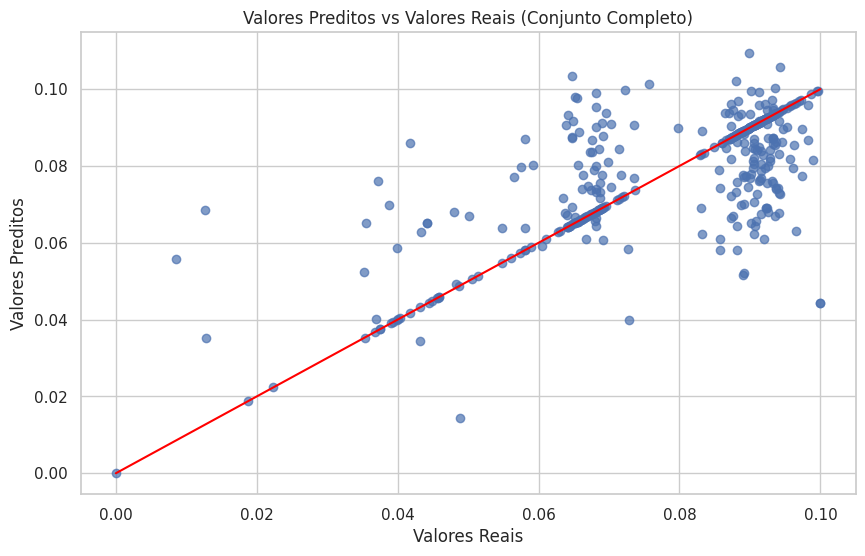

R² para o conjunto completo: 0.9748


In [ ]:
# Se X_full tiver a coluna constante, remova antes de fazer a predição
if 'const' in X_full.columns:
    X_full = X_full.drop(columns=['const'])

# Realizar a predição para todo o DataFrame
y_pred_full = best_model.predict(X_full)

# Exibir as primeiras linhas do DataFrame com as predições
print(X_full.head())

# Plotar valores preditos versus valores reais para todo o DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_full, alpha=0.7)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Linha de identidade
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Preditos vs Valores Reais (Conjunto Completo)')
plt.grid(True)
plt.show()

# Calcular o R² para o conjunto completo
final_r2_full = sm.OLS(y, y_pred_full).fit().rsquared
print(f"R² para o conjunto completo: {final_r2_full:.4f}")
